
### Computational Guided Inquiry for Modeling Earth's Climate (Neshyba, 2023)

# AdaptiveFlows

## Overview
Figure 1 below shows some carbon fluxes in Earth's climate system. Values in yellow are the preindustrial values, with values in red indicating changes as of the year 2005.
 
<p style='text-align: center;'>
<img src="http://webspace.pugetsound.edu/facultypages/nesh/Notebook/carbon_cycle.jpg" height="500" width="500"/>  
<strong>Figure 1</strong>. Carbon fluxes through Earth's climate system. Source: https://earthobservatory.nasa.gov/features/CarbonCycle.
</p>

Of course, with the influx of anthropogenic carbon, the numbers are different today: the annual anthropogenic flux is much bigger than the 9 GtC this figure shows. But another difference has nothing (directly) to do with that change, but rather with the fact that these fluxes are also dependent on the *concentrations* of carbon in various parts of the system, and on the *temperature* of those parts of the system. The idea of this module is to take a step in increasing our ability to represent such nuances by considering one of the most fundamental of these flows, namely how the flux of carbon from the atmosphere to Earth's terrestrial surface depends on these two variables.


## First-order kinetics
A key point about the flow of carbon out of the atmosphere is that it generally depends on how much carbon is in the atmosphere. This idea can be represented mathematically as 

$$
F_{atm->land} = k_{al0} + k_{al1} [C_{atm}] \ \ \ \ (1) 
$$

where $k_{al0}$ and $k_{al1}$ are what we call a *rate constants*, and $[C_{atm}]$ is the *reservoir amount* (or *concentration*) of carbon in the air, e.g., https://worldoceanreview.com/en/wor-1/ocean-chemistry/co2-reservoir/. Equation (1) represents what is called a *1st-order kinetic* approach to climate modeling; other names for it include *box modeling* and *stock-and-flow modeling* (see, e.g., https://publish.illinois.edu/olaogunbayo/2015/11/17/2-box-models-and-climate/).

It's worth noting something about the $k_{al1} [C_{atm}]$ term in Eq. 1. It embodies the idea of $CO_2$ fertilization. How? All else equal, as more $CO_2$ is added to the atmosphere, $[C_{atm}]$ goes up, and therefore the flux of carbon from the atmosphere to the land, $F_{atm->land}$, also goes up. So $CO_2$ fertilization is built into our model already!

## Adaptive first-order kinetics

As alluded to above, a problem one encounters with 1st-order kinetics in the context of climate change is that the "rules of the game" can be expected to be different in a future climate in which the temperature is higher. You can imagine that as Earth's temperature approaches some threshold value, processes like burning, drought, and beetle infestation could impair the ability of Earth's surface to sequester carbon (see, e.g., https://news.stanford.edu/2017/12/11/decades-increased-burning-depletes-soil-carbon/). This is an instance of a more general idea you are familiar with, namely *climate feedbacks*.

One way of incorporating this feedback would be to modify Eq. (1) to include an additional factor, $\sigma_{floor}$:

$$
F_{atm->land} = k_{al0} + \sigma_{floor} k_{al1} [C_{atm}]  \ \ \ \ (2)
$$

We envision $\sigma_{floor}(T)$ to be a step function that embodies the fact that, in a warmer climate, the ability of  Earth's surface to capture carbon will be reduced to some new, smaller value. In other words, at low temperatures, $\sigma_{floor}=1$, and we have the "usual", pre-industrial kind of photosynthetic behavior. But , but above some threshold temperature, $\sigma_{floor}$ drops to a new value, smaller than 1, representing an impairment of photosynthetic capture of atmospheric $CO_2$.

## Sigmoidal algorithms
You'll probably say at this point, don't we already have a step function, $\sigma_{down}(t)$? And the answer is Yes! But we are going to use them differently: whereas $\sigma_{down}(t)$ was used to describe a *time-dependent* step-down, $\sigma_{floor}(T)$ will be used to describe a *temperature-dependent* step-down. Therefore $\sigma_{floor}(T)$ will need to be equipped with a *temperature* threshold defining the temperature at which we think the change will kick in, and another parameter that specifies the *temperature range* over which this kicking-in will take place. Here, we'll call these values $T^*$ and $\Delta T_{trans}$, respectively. 

There is one significant algorithmic difference between $\sigma_{down}(t)$ and $\sigma_{floor}(T)$, however. 
Whereas $\sigma_{down}(t)$ steps down to zero at large values of $t$, $\sigma_{floor}(T)$ will need a *floor* at large values of $T$, to represent the fact that Earth's ability to capture carbon will drop to some new, presumably smaller value, but not all the way to zero (we hope), in a hotter climate. So that means $\sigma_{floor}(T)$ will need a third parameter, namely, the value of that floor. 

## A caveat
Implicit in the foregoing is the assumption that $\sigma_{floor}$ will *drop* a little in a warmer world. We should note that there is not universal consensus on this, however. Some have argued that whatever replaces forests could sequester *more* atmospheric carbon! (See https://climatechange.ucdavis.edu/news/grasslands-more-reliable-carbon-sink-than-trees/). Nevertheless, it is commonplace to treat assumptions like this assumption as contingently valid, for the purpose of exploring what its consequences might be.

## Learning Goals

- I can describe the physical ideas behind the mathematics of first-order kinetics, including the meaning behind all the terms in Eq. (2).
- I can describe, and implement code for, adaptive first-order kinetics, in terms of a step function.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5io

In [2]:
%matplotlib notebook

### Getting a sense for the pre-industrial atmosphere->land flux.

Before getting started with Eq. (2), it's useful to get a sense of how Eq. (1) would predict pre-industrial fluxes. To do this, you need to know a few things:

1. Pre-industrial $CO_2$ concentrations were about 290 ppm.
1. To convert from ppm to $GtC$, multiply by 2.12.
1. A reasonable value of the rate constants in Eq. (1) are as follows:

        k_al0 = 113
        k_al1 = 0.0114

In the cell below, compute and print the pre-industrial $CO_2$ concentration (in GtC). Then use Eq. (1) to compute and print the pre-industrial flux of carbon from the atmosphere to Earth's surface. If the value you get seems huge -- like ~100 GtC/year -- don't be dismayed: 100 GtC/year corresponds to a little less than 1 kg of carbon sequestered by every square meter of land, per year.

614.8000000000001
flux =  120.00872
1/k_al1 =  87.71929824561403
C_ppm in 2005:
413.7702747434624
fluxdensity =  0.8000581333333333


<IPython.core.display.Javascript object>


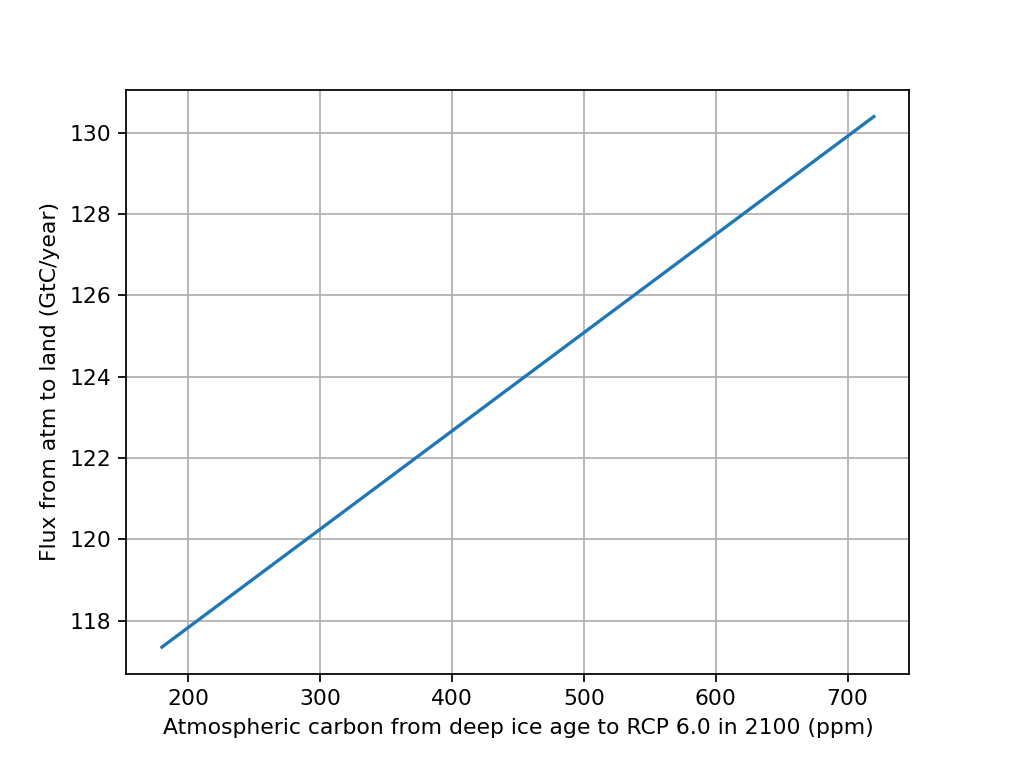

<IPython.core.display.Javascript object>


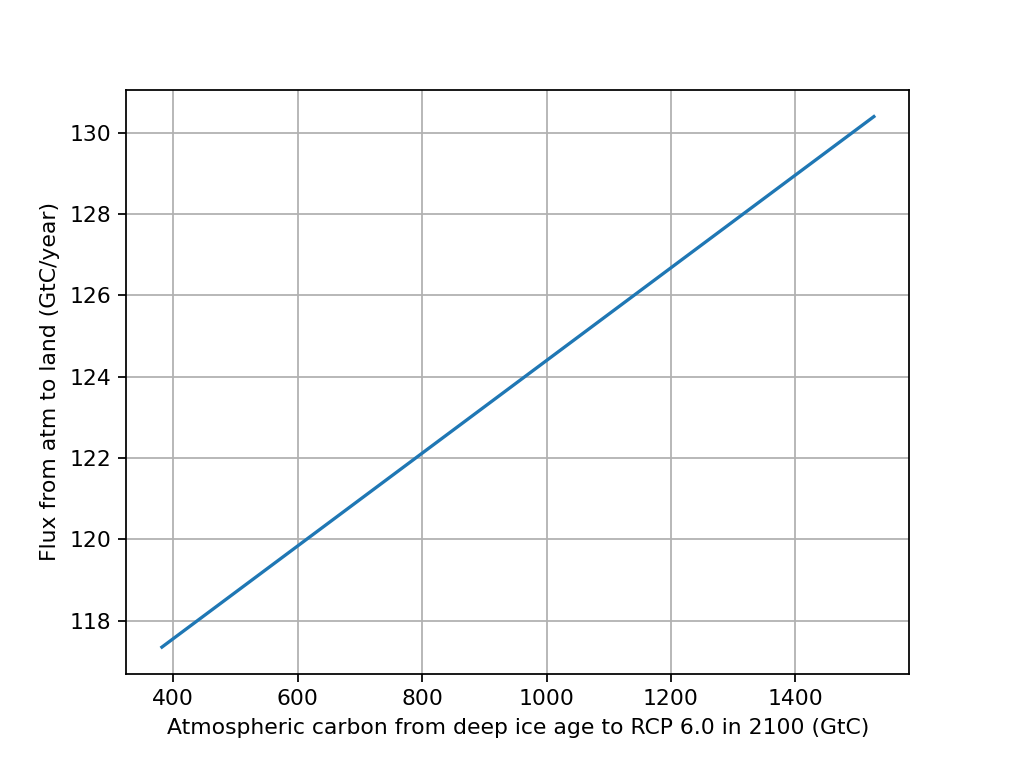

In [3]:
### BEGIN SOLUTION
k_al0 = 113 
k_al1 = 0.0114
C_ppm_preindustrial = 290
C_atm = C_ppm_preindustrial*2.12
flux = k_al0 + k_al1*C_atm

print(C_atm)
print('flux = ', flux)
print('1/k_al1 = ', 1/k_al1)

print('C_ppm in 2005:')
C_ppm_2005 = (123-k_al0)/k_al1/2.12
print(C_ppm_2005)

LandArea = 1.5e8*1e6 # m^2
fluxdensity = flux*1e9*1000/LandArea
print('fluxdensity = ', fluxdensity)

# Not part of the solution, but maybe should have been: illustration of this flux
C_ppm_array = np.linspace(180,720)
C_atm_array = C_ppm_array*2.12
flux_array = k_al0 + k_al1*C_atm_array
plt.figure()
plt.plot(C_ppm_array,flux_array)
plt.xlabel('Atmospheric carbon from deep ice age to RCP 6.0 in 2100 (ppm)')
plt.ylabel('Flux from atm to land (GtC/year)')
plt.grid(True)

plt.figure()
plt.plot(C_atm_array,flux_array)
plt.xlabel('Atmospheric carbon from deep ice age to RCP 6.0 in 2100 (GtC)')
plt.ylabel('Flux from atm to land (GtC/year)')
plt.grid(True)

### END SOLUTION

### Adaptive flows with temperature-dependent rate constants

Now we're going to tackle the adaptive part of this exercise -- namely, Eq. (2). To help with this, we've provided a Python function corresponding to $\sigma_{floor}(T)$ in the cell below. Execute the cell to activate it.

In [4]:
def sigmafloor(T,Tstar,deltaT,floor):
    # Generates a sigmoid (smooth step-down) function with a floor 
    # The floor should be given as a fraction (i.e., between 0 and 1)
    temp = 1 - 1/(1 + np.exp(-(T-Tstar)*3/deltaT))
    return temp*(1-floor)+floor

### Trying out the $\sigma_{floor}(T)$ function
The cell below is meant to show you how to use our $\sigma_{floor}(T)$ function, but instead of a single temperature at which to evaluate $\sigma_{floor}(T)$, we're going to give it an *array* of temperatures, starting at the pre-industrial global average of 287 K, rising up to the temperature predicted by the (very pessimistic) RCP8.5 scenario of about five degrees warming. This is so we can see what the transition across the threshold looks like. In addition,

1. The threshold temperature we called $T^*$ in the Introduction is specified here by the Python variable Tstar; here, we've set it to 2 degrees Celsius above the preindustrial temperature, so 289 K.
1. The range of temperatures over which the transition occurs is specified here by the Python variable deltaT; here, we're saying this is one degree C.
1. The new, post-apocalyptic value of $\sigma_{floor}(T)$ is 70%. That would mean, in our new, warmer world, the ability of land surfaces to absorb atmospheric carbon has been reduced to 70% of what they could do in pre-industrial times.

<IPython.core.display.Javascript object>


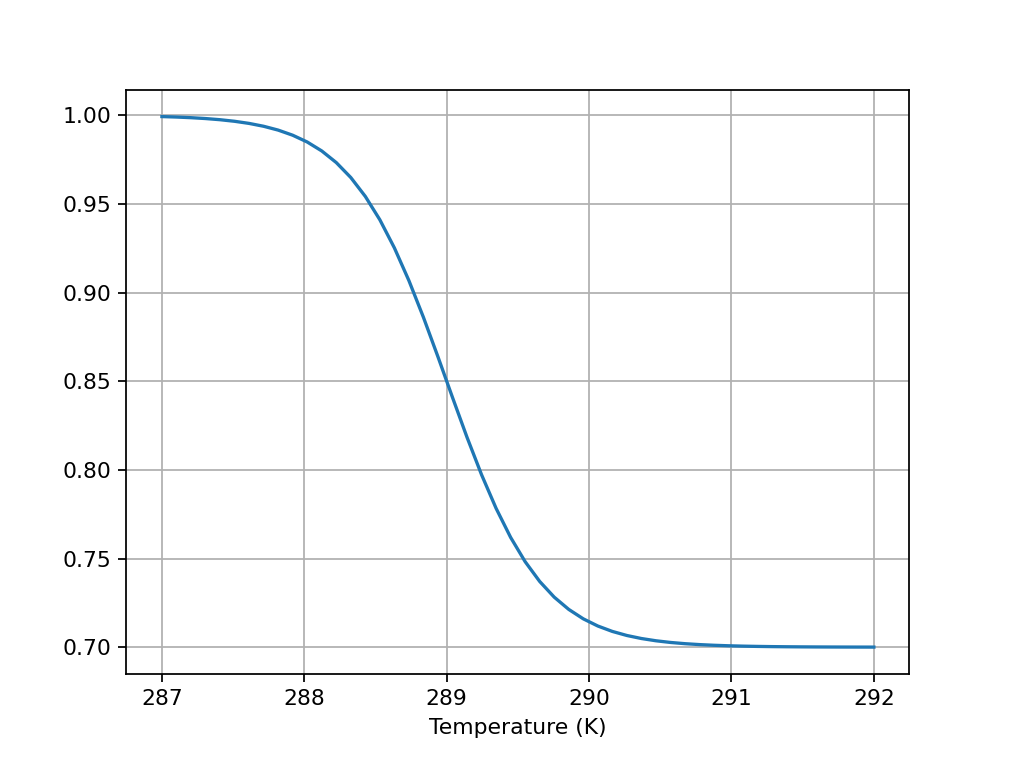

Text(0.5, 0, 'Temperature (K)')

In [5]:
T = np.linspace(287,292)
Tstar = 289
deltaT = 1
floor = 0.70
plt.figure()
mysigmafloor = sigmafloor(T,Tstar,deltaT,floor)
plt.plot(T,mysigmafloor)
plt.grid(True)
plt.xlabel('Temperature (K)')

### Your turn
In the cell below, duplicate what you did above, with the same temperature array (i.e., T) just considered, but with the sole difference that there is a sharper transition -- say, a deltaT value of 0.5 degrees.

Then plot $\sigma_{floor}$ as a function of the array of temperatures ($T$).

<IPython.core.display.Javascript object>


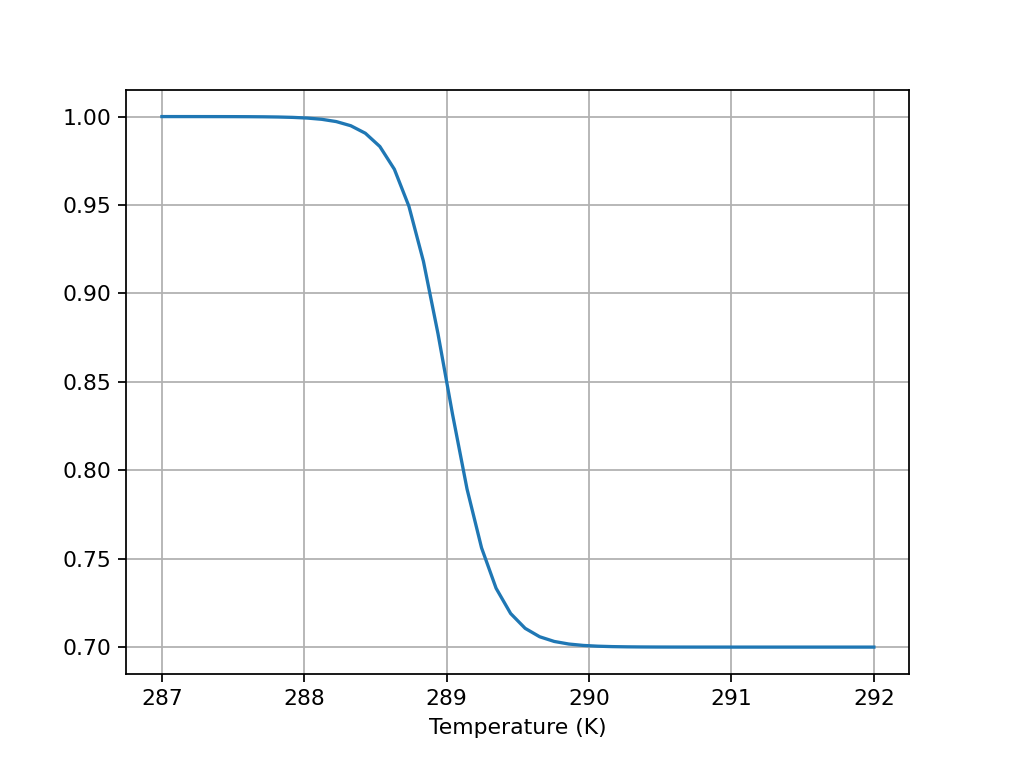

Text(0.5, 0, 'Temperature (K)')

In [6]:
### BEGIN SOLUTION
deltaT = .5
plt.figure()
mysigmafloor = sigmafloor(T,Tstar,deltaT,floor)
plt.plot(T,mysigmafloor)
plt.grid(True)
plt.xlabel('Temperature (K)')


# plt.figure()
# plt.plot(T,mysigmafloor*k_al)
# plt.grid(True)
# plt.xlabel('Temperature (K)')
# plt.ylabel('sigmafloor x k_al')
### END SOLUTION

### Pause for Analysis
Considering the two scenarios just presented, make an argument for which you think would be "better" or "worse" (arguments can be imagined on both sides).

### BEGIN SOLUTION

### END SOLUTION

### Examining the adaptive flux

To put the above in more physical terms, we're going to compare the flux represented by Eq. 2 over the same range of temperatures. This is easy -- you'll just multiply the appropriate term by the factor (array) $\sigma_{floor}$ you just got, and plot the result as a function of temperature.

<IPython.core.display.Javascript object>


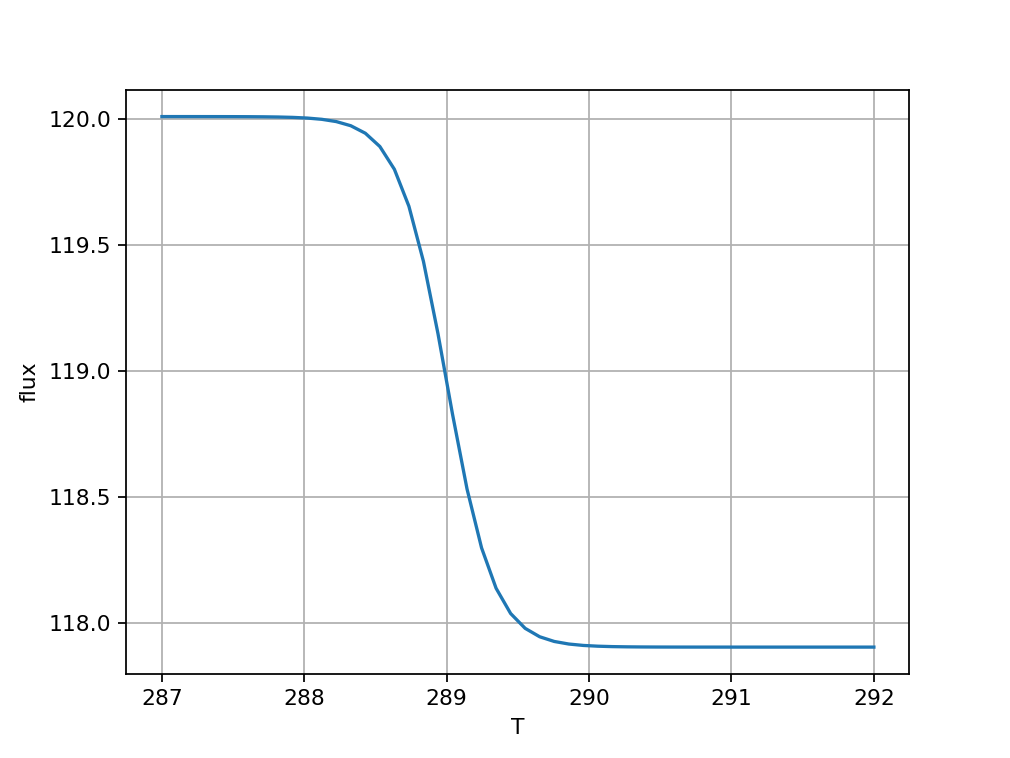

Text(0, 0.5, 'flux')

In [7]:
### BEGIN SOLUTION
flux = k_al0 + mysigmafloor*k_al1*C_atm
plt.figure()
plt.plot(T,flux)
plt.grid(True)
plt.xlabel('T')
plt.ylabel('flux')
### END SOLUTION

### Pause for analysis
The low-temperature value of the atmosphere-to-land flux you just calculated should correspond to a value you can find in Fig. 1. Where is that value in the figure, what are its units, and how is it labeled?

### BEGIN SOLUTION
Upper left, 120 GtC/year
### END SOLUTION

### Refresh/save/validate
Almost done! To double-check everything is OK, repeat the "Three steps for refreshing and saving your code," and press the "Validate" button (as usual).

### Close/submit/logout
1. Close this notebook using the "File/Close and Halt" dropdown menu
1. Using the Assignments tab, submit this notebook
1. Press the Logout tab of the Home Page